<a href="https://colab.research.google.com/github/WaterPurify/Alpaco_Bootcamp/blob/main/2_Natural%20Language%20%26%20Speech%20Recognition/Team_project/WhisperAI_fine_tune_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤗 Transformer를 적용한 다국어 자동 음성 (ASR)을 Whisper에 fine-tuning

*   Step-by-step guide on how to fine-tune Whisper for any multilingual ASR dataset using Hugging Face 🤗 Transformers.
*   For a more in-depth explanation of Whisper, the Common Voice dataset and the theory behind fine-tuning, the reader is advised to refer to the blog post.[blog post](https://huggingface.co/blog/fine-tune-whisper).



## Introduction

*   Whisper
    * A pre-trained model for automatic speech recognition (ASR) published in September 2022 by the authors Alec Radford et al. from OpenAI.
    *  Pre-trained on a vast quantity of labelled audio-transcription data, 680,000 hours to be precise
    * Demonstrate a strong ability to generalise to many datasets and domains


<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

* Five configurations of varying model sizes.
    1. The smallest four trained on either English-only or multilingual data.
    2. The largest checkpoints  multilingual only.
    
* All 11 of the pre-trained checkpoints are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper).

* The checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


* Fine-tune the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
* Train and evaluate our system on a low-resource language
taken from the [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
dataset.
* 8 hour fine-tuning of Whisper AI can acheive strong performance in our Korean language for old peaple.

## Prepare Environment

1. GPU setting
    *  click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 24 03:53:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

* Employ poplular Pytohn packages

    1. Use `datasets[audio]` to download and prepare our training data
    2. `Transformers` and `accelerate` to load and train our Whisper model
    3. `soundfile` package to pre-process audio files
    4. `evaluate` and `jiwer` to assess the performance of our model
    5. `tensorboard` to log our metrics
    6.  `gradio` to build a
flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━

In [ ]:
#spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
!pip install typer==0.9.1


In [ ]:
#tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.

!pip install tensorboard==2.15.0

In [ ]:
#weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
!pip install weasel==0.3.4

* Upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training.

* The Hub provides:
    - Integrated version control: you can be sure that no model checkpoint is lost during training.
    - Tensorboard logs: track important metrics over the course of training.
    - Model cards: document what a model does and its intended use cases.
    - Community: an easy way to share and collaborate with the community!

- Linking the notebook to the Hub is straightforward  

* Entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [ ]:
# Huggingface 로그인
from huggingface_hub import notebook_login

notebook_login()

# Load Dataset

* Using 🤗 Datasets, download and prepare data

    1. Ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_12_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_12_0).

    2. 5 hours of korean dataset is considered low-resource, so we decided to use dataset from [AI hub](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=123) which has more than 1000 hours with 2000 speakers.



In [ ]:
# 학습이랑 테스트 데이터 불러오기
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="test", use_auth_token=True)

print(common_voice)



* Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`).

    * Common Voice contains additional
      metadata information, such as `accent` and `locale`, which we can disregard for ASR.

* For only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [ ]:
# Common_voice안에 필요없는 column 제거하기
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

print(common_voice)

# Prepare Feature Extractor, Tokenizer and Data

ASR pipeline de-composed into three-stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.



### Load WhisperFeatureExtractor

The whisper feature extractor with two operations:

1. Pads/truncate the audio inputs to 30s: any audio inputs shorter than 30s padded to 30s with silence(zeros), and those longer than 30s truncated to 30s

2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

Load the feature extractor from the pre-trained checkpoint with the default values:

In [ ]:
# WhisperFeatureExtractor를 통해서 pre-traine checkpoint 가져오기
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

### Load WhisperTokenizer

* Outputs a seqeuence of _token ids_
* Tokenizer maps each of these token ids to their corresponding text string
* For Korean, load the pre-trained tokenizer and use it for fine-tuning without any further modifications
    
    * Specify the target language and the task

    *  The tokenizer to prefix the language and task tokens to the start of encoded label sequences:

In [ ]:
# WhisperTokeinzer를 통해서 원하는 task 언어를 토큰화 진행하기
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")

### Combine To Create A WhisperProcessor

* To simplify using the feature extractor and tokenizer
 * Wrap both into a single WhisperProcessor class
    
 * Inherits from the WhisperFeatureExtractor and WhisperProcessor

 * Can be used on the audio inputs and model predictions as required

* Keep track of two objects during training: the processor and the model:


In [ ]:
# WhisperProceesor는 작업하는 언어와 작업을 설정하기
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")

### Prepare Data

Print the first example of the Common Voice dataset

In [ ]:
print(common_voice["train"][0])

* Input audio sampled at 48 kHz -> downsample to 16kHz before pass to the Whisper feature extractor
    
    * 16 kHz the sampling rate expected by the Whisper model

* Using dataset's [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column) method => Able to set the audio inputs to the correct sampling rate

    * Resample audio sample _on the fly_ the first time that they are loaded

In [ ]:
# Cast column 방법을 통해 원하는 sampling rate로 설정 가능
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Now write a function to prepare our data ready for the model:

 1. Load and resample the audio data by calling `batch["audio"]`.
 2. Use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array
 3. Encode the transcriptions to label ids through the use of the tokenizer.

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

* Apply the data prepartation function  to all our training examples using dataset's `.map` method

    * `num_proc`: How many CPU cores to use (`num_proc` > 1 will enable multiprocessing)





In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

### Training and Evaluation

####Training pipeline

The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) do much of the heavy lifting for us

 - Load a pre-trained checkpoint: Need to load a pre-trained checkpoint and configure it correctly for training.

 - Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model

 - Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation

 - Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule

 After fine-tuned the model, evaluate it on the test data to verify it on the test data to verfify if we trained correlty to transcribe speech in Korean.




### Load a Pre-Trained Checkpoint

* Use the pre-trained Whisper `small` checkpoint (the weights for which we need to load from the Hugging Face Hub)


In [ ]:
# 이 모델은 조건부 생성(conditional generation)을 위해 설계되었으며, 주어진 입력에 대해 텍스트를 생성하는 작업을 수행
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

### Diable the automatic language detection task

*  set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config

* set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None (Default setting)

In [ ]:
model.generation_config.language = "hindi"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

#### Define a Data Collator

* Sequence-to-sequence speach model: the `input_features` and `labels` independently

 * the  `input_features` by the feature extractor
 * the `labels` by the tokenizer

* The `input_features` padded to 30s and converted to a log-Mel spectrogram of fixed dimension by action of the feature extractor

* Convert the `input_features`
to batched PyTorch tensors
 * Use the feature extractor's `.pad` method with `return_tensors=pt`

* The `labels` un-padded
 1. Pad the sequences to the maximum length in the batch using the tokenizer's `.pad` method
 2. Padding tokens replaced by  `-100` :**not** taken into account when computing the loss
 3. Cut the BOS (Beginning of sentence) token from the start of the label sequence (append it later during training)



In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

* Use the word error rate (WER) metric, the 'de-facto' metric for assessing ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer).

In [ ]:
import evaluate

metric = evaluate.load("wer")

* Define a function that takes our model predictions and returns the WER metric
    * Called
     `compute_metrics`, first replaces `-100` with the `pad_token_id` in the `label_ids` (undoing the step we applied in the data collator to ignore padded tokens correctly in the loss).

1. Decodes the predicted and label ids to strings
2. Computes the WER between the predictions and reference labels:

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

* Define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ko",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`

Forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

Save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [ ]:
processor.save_pretrained(training_args.output_dir)

### Training

* Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab


For prevent the training without interrupted due to inactivity in Colab

* Insert the code into the console of the this tab (_right mouse click_-> _inspect_ -> _Console tab_ -> _insert code_)

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for given configuration: approximately 15.8 GB.
 * Depending on the GPU allocated to the Google Colab, Encounter a CUDA `"out-of-memory"` error when launching training => reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

* Gradient Accumulation 방법은 미니 배치를 통해 구해진 gradient를 n-step동안 Global Gradients에 누적시킨 후, 한번에 업데이트하는 방법입니다. 예를 들어서 현재 batch size가 16이고 n-step 값이 16이면 batch size 16으로 16번의 gradient 축적을 통해서 한번의 forward/back propagation을 실행한다. 이렇게 되면 실제로 배치사이즈 256을 사용한 효과를 얻을 수 있으나, 훈련시간이 매우 길어질 수 있다는 단점

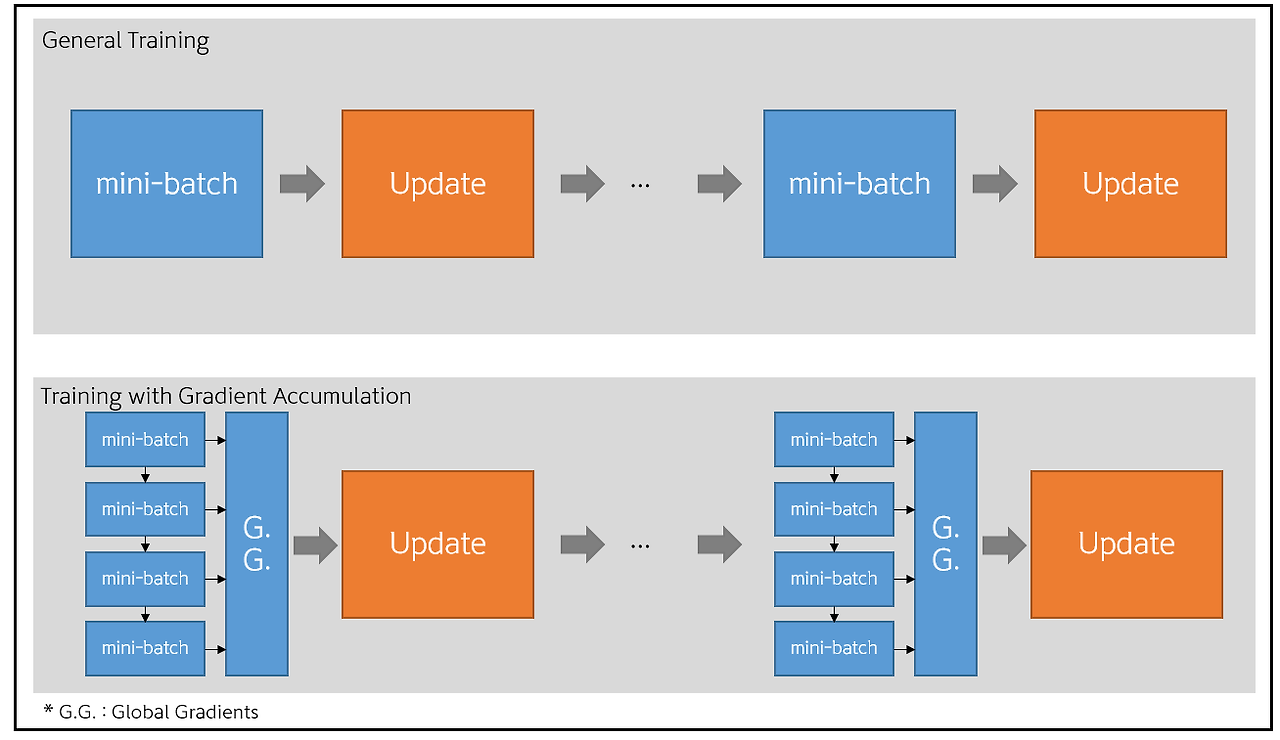

Launch training with simple code below

In [ ]:
trainer.train()


* Able to make our model more accessible on the Hub with appropriate tags and README information.

* Able can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Whisper Small Hi - Sanchit Gandhi",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

Training results now be uploaded to the Hub
* Excecute the `push_to_hub` command and save the preprocessor object we created:

In [ ]:
trainer.push_to_hub(**kwargs)